In [1]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda
from numba import vectorize, int64, float32


## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
#vectorized version of log
@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def vec_log(x):
    c =  np.log(x) #ln
    return c

A=np.array([2, 5, 10, 3, 8], dtype=np.float32)
print("Vectorized version of log: ",vec_log(A))


#vectorized version of exp 
@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def vec_exp(x):
    c =  np.exp(x) 
    return c

print("Vectorized version of exp: ",vec_exp(A))


Vectorized version of log:  [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Vectorized version of exp:  [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
#code ex2
from scipy import stats
from scipy.stats import truncnorm
from numba import jit, int32, float64


@jit(nopython=True) #compiler generate code with the highest performance, but all native types of all values in the function can be inferred.
def pdf(x, mu, sigma):
    return (1/np.sqrt(2*math.pi)*sigma)*np.exp((-1/2)*((x-mu)/(sigma))**2)

mu, sigma = 1,1
N=100000
x_values = np.linspace(-3,3, N).astype(np.float32)
pdf(x_values,1,1)



array([0.00013383, 0.00013386, 0.00013389, ..., 0.05400392, 0.05399745,
       0.05399097])

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

Text(0.5, 1.0, 'Data after zero_suppress function')

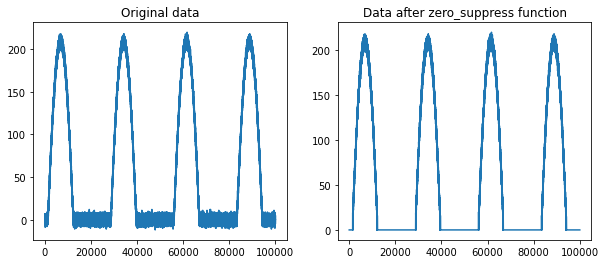

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#Create a "zero suppression" function. 
#force all samples values below a certain absolute magnitude to be zero, to eliminate low amplitude noise. 

magnitude_max=15 

@vectorize
def zero_suppression(magnitude_max,x):
        if x < magnitude_max:
            x=0
        return x
    
new_data=zero_suppression(magnitude_max,data)

#Plot the data before and after the application of the zero_suppress function.
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(data)
ax1.set_title("Original data",fontsize=12)

ax2.plot(new_data)
ax2.set_title("Data after zero_suppress function",fontsize=12)

    

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@cuda.jit(device=True)
def k(x,y,a,c):
    return np.tanh(a*x.T*y+c)

print(k(X,Y,1,1))

[[0.84769124 0.94776557 0.92364462]
 [0.79714073 0.86139472 0.8319486 ]
 [0.84643686 0.84675072 0.85583931]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
#code ex5

# CUDA kernel
@cuda.jit
def kernel3D(array):
    i,j,k = cuda.grid(3)
    if i < array.shape[0] and j < array.shape[1] and k<array.shape[2]:
        array[i][j][k] = np.cos(array[i][j][k])

# Host code   
data = np.random.random((32,32,32)) #lower dimention to be able to run the conde on my computer
#data = np.random.random((256,256,256)) #with the asked matrix dimension 

# Configure the blocks 
threadsperblock = (16,16,16)
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

#print("lla \n",data)
kernel3D[blockspergrid, threadsperblock](data)
print(data)


[[[0.97889193 0.93375617 0.95068755 ... 0.47155234 0.80634581 0.81913299]
  [0.99943187 0.98064517 0.97486208 ... 0.51158848 0.54871188 0.65908531]
  [0.92667353 0.99698858 0.99826328 ... 0.34930096 0.6906221  0.87717595]
  ...
  [0.94181188 0.84911837 0.94633369 ... 0.39504569 0.82512489 0.47297286]
  [0.7978837  0.72674326 0.98317239 ... 0.47137405 0.93981425 0.33475091]
  [0.84554164 0.74119641 0.88794818 ... 0.17797828 0.75713338 0.25651773]]

 [[0.79246825 0.99417775 0.99295446 ... 0.87467789 0.77914364 0.15806902]
  [0.84181518 0.89720044 0.92660194 ... 0.82848114 0.15880045 0.19970539]
  [0.81737423 0.96735869 0.67154529 ... 0.08997738 0.64573914 0.09573993]
  ...
  [0.71212917 0.97747435 0.89773971 ... 0.40922802 0.80502822 0.62481564]
  [0.99833417 0.99143921 0.95227632 ... 0.63397298 0.85233403 0.18670009]
  [0.98659924 0.86412258 0.94656533 ... 0.40192899 0.35982492 0.15394561]]

 [[0.95848219 0.88667626 0.62812948 ... 0.87510829 0.12096103 0.45925053]
  [0.54043977 0.997377

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [7]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(1,3,(24,12)) #check randint
B = np.random.randint(1,3,(12,22))   
C = np.zeros((24, 22))

# Configure the blocks
threadsperblock = (16,16)
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

#kernel 
matmul[blockspergrid, threadsperblock](A,B,C)
print(C)



[[26. 28. 32. 26. 28. 32. 25. 31. 33. 25. 30. 29. 29. 25. 25. 27. 32. 32.
  31. 33. 29. 24.]
 [26. 22. 28. 24. 27. 29. 24. 27. 29. 22. 27. 26. 28. 22. 24. 23. 27. 27.
  28. 27. 28. 21.]
 [24. 24. 28. 25. 27. 27. 23. 29. 29. 23. 27. 27. 27. 22. 24. 23. 27. 26.
  27. 28. 28. 21.]
 [25. 24. 29. 24. 26. 28. 23. 27. 30. 22. 27. 25. 27. 22. 22. 24. 28. 28.
  29. 28. 27. 20.]
 [26. 28. 32. 27. 28. 32. 25. 32. 33. 26. 30. 29. 29. 24. 25. 26. 31. 31.
  30. 33. 30. 24.]
 [24. 24. 29. 24. 26. 30. 22. 27. 30. 23. 26. 27. 27. 22. 23. 24. 26. 26.
  27. 28. 28. 21.]
 [25. 24. 29. 25. 25. 29. 22. 29. 31. 23. 26. 28. 28. 22. 22. 24. 26. 25.
  25. 27. 27. 21.]
 [22. 23. 27. 22. 24. 27. 22. 27. 28. 22. 27. 26. 26. 24. 22. 24. 24. 25.
  25. 27. 24. 20.]
 [24. 27. 30. 25. 25. 30. 22. 31. 33. 25. 28. 29. 27. 24. 22. 27. 29. 29.
  27. 31. 27. 23.]
 [30. 27. 33. 28. 30. 33. 28. 33. 35. 26. 32. 31. 33. 27. 27. 29. 31. 31.
  32. 32. 33. 24.]
 [24. 24. 28. 24. 24. 29. 22. 29. 30. 23. 27. 28. 27. 23. 21. 24. 26. 